# 1. Data Preparation and Visualization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from tqdm import tqdm

In [25]:
# Définition des transformations
transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor()
])

batch_size = 512

# Chargement complet du dataset
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
val_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class_labels = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

# 2. Define the VAE Model

**a. Why do we need separate heads for μ and log⁡(σ2)?**

We need separate heads for μ (mean) and log(σ²) (log variance) because they have different roles. The mean decides the center of the distribution, while the variance controls how spread out it is. Using log(σ²) instead of σ² ensures the variance stays positive and helps with stable training.

<hr>

**b. How does the reparameterization trick help with backpropagation through stochastic nodes?**

The reparameterization trick helps with backpropagation by making the sampling process smooth and differentiable. Instead of randomly choosing a value inside the network, we split the randomness into a separate part. This way, the network can still learn properly because we can compute gradients and update the model during training.

In [12]:
class VAE(nn.Module):
    def __init__(self, input_shape=(1, 32, 32), latent_dim=2):
        """
        Variational Autoencoder initialization.

        Args:
            input_shape (tuple): Shape of the input image. Default is (1, 32, 32).
            latent_dim (int): Dimension of the latent representation.
        """
        super(VAE, self).__init__()

        # ------------------
        #     1. Encoder
        # ------------------
        # This block progressively reduces the spatial dimension of the input.
        # Each Conv2D layer uses stride=2 to downsample.
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Dynamically calculate the flattened size after all convolution layers
        flattened_size, decode_shape = self.calculate_flattened_size(self.encoder, input_shape)

        # ------------------------------------------------
        #     2. Fully Connected Layers for Latent Space
        # ------------------------------------------------

        # Two separate heads for the VAE:
        #  - fc_mu: Predicts the mean of the latent distribution
        #  - fc_logvar: Predicts the log-variance of the latent distribution
        self.fc_mu = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(flattened_size, latent_dim)  # Latent mean
        )

        self.fc_logvar = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(flattened_size, latent_dim)  # Latent log variance (Hint: same dimension as mu)
        )

        # ------------------
        #     3. Decoder
        # ------------------
        # Inverts the encoder process with ConvTranspose2d (a.k.a. deconvolutions).
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, flattened_size),  # Map latent space back to the feature map
            nn.Unflatten(decode_shape[0],decode_shape[1:]),  # Reshape to match the encoded feature map
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # Add a conv transpose 2d
            nn.ReLU(), # activation function


            # Next deconvolution layer
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Add a ConvTranspose2d layer reducing from 64 channels to 32 channels and  kernel_size=3, stride=2, padding=1, output_padding=1
            nn.ReLU(), # activation function

            # Final deconvolution layer: Convert back to single-channel grayscale image
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # activation function
            # Output values should be between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick:

        z = mu + sigma * eps, where eps ~ N(0, I)

        Args:
            mu (Tensor): Mean of the latent distribution.
            logvar (Tensor): Log-variance of the latent distribution.

        Returns:
            z (Tensor): Latent variable sampled from N(mu, sigma^2).
        """
        std = torch.exp(0.5 * logvar)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)    # Sample noise from a normal distribution
        return mu + logvar * eps

    def calculate_flattened_size(self, model, input_shape):
       #same as the last one
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = model(dummy_input)
            return output.numel(), output.shape

    def forward(self, x):
        """
        Forward pass for the VAE:

        1) Encode input into latent distribution parameters (mu, logvar).
        2) Sample z using the reparameterization trick.
        3) Decode z back to a reconstructed image.

        Args:
            x (Tensor): Input images.

        Returns:
            recon_x (Tensor): Reconstructed images.
            mu (Tensor): Mean of latent distribution.
       logvar (Tensor): Log-variance of latent distribution.
            z (Tensor): Sampled latent variable.
        """
        # Encode input
        x_encoded = self.encoder(x)

        # Compute mu and logvar
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)

        # Sample from the latent distribution
        z = self.reparameterize(mu, logvar)

        # Decode latent vector to reconstruct the input
        recon_x = self.decoder(z)

        return recon_x, mu, logvar, z

In [13]:
# Test dimension consistency
x_sample = torch.randn(1, 1, 32, 32)  # Example input
model_test = VAE()
image_test, mu, logvar, z = model_test(x_sample)
assert image_test.shape == x_sample.shape, "Output dimensions do not match input dimensions!"


# 3. VAE Loss Function and Training

**c. How does a larger β value change the trade-off between reconstruction quality and latent disentanglement?**

A larger β value increases the weight of the KL divergence term in the loss function, which affects the trade-off between reconstruction quality and latent disentanglement:

- Higher β → More Disentanglement, Worse Reconstruction: The model is forced to make the latent space more structured and independent, meaning each latent variable captures a more meaningful and separate feature. However, this can reduce reconstruction quality because the model cannot store as much detailed information in the latent space.
- Lower β → Better Reconstruction, Less Disentanglement: When β is small (or 1 in standard VAEs), the model focuses more on reconstructing the input accurately, allowing it to encode more details. However, this can lead to entangled representations where different latent variables mix information instead of capturing separate features.

So, increasing β pushes the model towards better disentanglement but at the cost of lower reconstruction quality.

In [16]:
#######################
# 1. Define VAE Loss
#######################
def vae_loss(recon_x, x, mu, logvar, beta=1):
    """
    Compute the Variational Autoencoder (VAE) loss function.
    A combination of:
      - Reconstruction loss (using BCE or MSE)
      - KL divergence regularizer

    Args:
      recon_x (Tensor): Reconstructed images from the decoder.
      x (Tensor): Original input images.
      mu (Tensor): Mean of the latent distribution.
      logvar (Tensor): Log-variance of the latent distribution.
      beta (float): Weight for the KL term (β-VAE concept).

    Returns:
      total_loss (Tensor): Sum of reconstruction loss and β * KL divergence.
    """

    # 1) Reconstruction Loss
    #    Measures how closely recon_x matches x.
    #    Typically use Binary Cross Entropy (BCE) if inputs are normalized [0,1].
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')


    # 2) KL Divergence
    #    Encourages the approximate posterior (q(z|x)) to be close to a
    #    standard normal prior p(z) ~ N(0,I).
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Return the total VAE loss
    return recon_loss + beta * kl_div

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#######################
# 2. Training Function
#######################
def train_model(model, train_loader, val_loader, epochs, beta=1):
    """
    Trains a VAE model with a given β for the KL term.

    Args:
      model (nn.Module): VAE instance (encoder + decoder).
      train_loader (DataLoader): Dataloader for training set.
      val_loader (DataLoader): Dataloader for validation set.
      epochs (int): Number of training epochs.
      beta (float): Weight for the KL divergence in the VAE loss.
    """

    # Choose an optimizer, e.g., Adam
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # Lists to store loss values for plotting
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to train mode
        total_loss = 0

        # Use tqdm to create a progress bar
        tqdm_loader = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}")

        for x, _ in tqdm_loader:
            # 1) Zero out gradients from previous iteration
            optimizer.zero_grad()

            # 2) Move the batch to the correct device (CPU, CUDA, or MPS)
            x = x.to(device)  # Fill in your device, e.g., device, "cuda", or "mps"

            # 3) Forward pass: encode -> reparameterize -> decode
            recon_x, mu, logvar, _ = model(x)

            # 4) Compute VAE loss
            loss = vae_loss(recon_x, x, mu, logvar, beta=beta)

            # 5) Backpropagation
            loss.backward()

            # 6) update grad
            optimizer.step()

            # Accumulate total loss for this batch
            total_loss += loss.item()

            # Update tqdm progress bar with the current batch loss
            tqdm_loader.set_postfix(loss=loss.item())

        # Average loss over all training samples
        avg_train_loss = total_loss / len(train_loader.dataset)

        # Evaluate on validation data
        avg_val_loss, _ = evaluate_model(model, val_loader)

        # Print epoch statistics
        print(
            f"Epoch [{epoch + 1}/{epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}"
        )

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    plot_training_loss(train_losses, val_losses)


#######################
# 3. Evaluation Function
#######################
def evaluate_model(model, loader ,beta=1.0):
    """
    Evaluates the VAE on a validation or test dataset.

    Args:
      model (nn.Module): VAE instance (encoder + decoder).
      loader (DataLoader): Dataloader for validation/test set.

    Returns:
      avg_loss (float): Average loss across all validation samples.
      ce_loss_placeholder (float): Placeholder if you want to track
                                   additional metrics or losses.
beta (float): Weight for the KL divergence in the VAE loss.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    ce_loss_placeholder = 0  # Example placeholder for separate metrics

    with torch.no_grad():
        for x, _ in tqdm(loader, desc="Evaluating"):
            x = x.to(device)  # Move data to the same device as the model

            # Forward pass to get reconstruction and latent variables
            recon_x, mu, logvar, _ = model(x)

            # Compute VAE loss (without adjusting gradients)
            loss = vae_loss(recon_x, x, mu, logvar, beta=beta)  # e.g., same β as training

            total_loss += loss.item()
            # Optionally compute or track other metrics here, e.g.:
            # ce_loss_placeholder += some_other_metric(...)

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, ce_loss_placeholder

def plot_training_loss(train_losses, val_losses):
    """
    Plot the training and validation loss across epochs.

    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", marker="o")
    plt.plot(val_losses, label="Validation Loss", marker="s")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

Training Autoencoder...


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.61it/s]


Epoch [1/10], Train Loss: 619.6244, Val Loss: 442.2470


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.43it/s]


Epoch [2/10], Train Loss: 416.8095, Val Loss: 386.0101


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.42it/s]


Epoch [3/10], Train Loss: 358.9749, Val Loss: 335.8402


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.32it/s]


Epoch [4/10], Train Loss: 326.6435, Val Loss: 314.0488


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.11it/s]


Epoch [5/10], Train Loss: 309.1366, Val Loss: 302.1824


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.35it/s]


Epoch [6/10], Train Loss: 299.1926, Val Loss: 294.9903


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.22it/s]


Epoch [7/10], Train Loss: 292.9957, Val Loss: 290.3247


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.20it/s]


Epoch [8/10], Train Loss: 288.8540, Val Loss: 287.1097


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s]


Epoch [9/10], Train Loss: 285.8207, Val Loss: 284.6753


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s]


Epoch [10/10], Train Loss: 283.3999, Val Loss: 283.0213


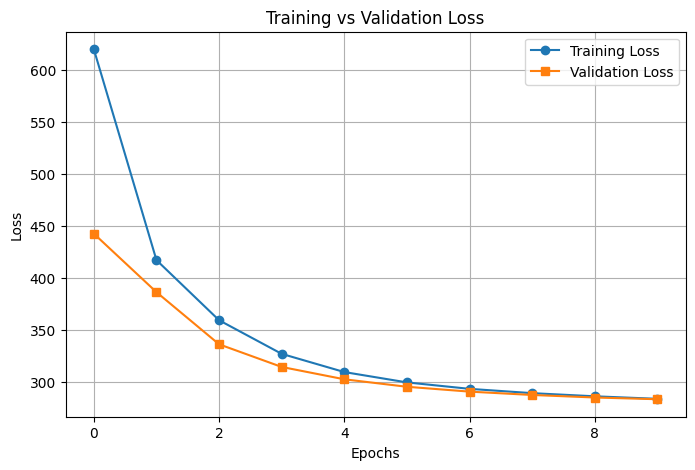

In [17]:
# Train and visualize Autoencoder
vae = VAE().to(device)
print("Training Autoencoder...")
train_model(vae, train_loader, val_loader, epochs=10,beta =1.5)

# 4. Reconstruct Images

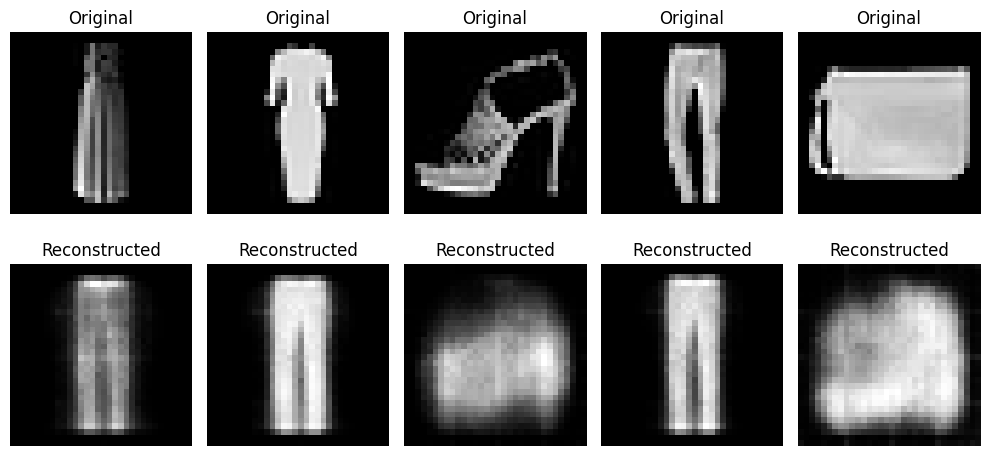

In [18]:
def plot_reconstructions(model, loader_or_z, ex=True, num_samples=5):
    """
    Plot original and reconstructed images from an Autoencoder (VAE).

    Parameters:
    - model: Trained VAE model.
    - loader_or_z: Either a DataLoader (for real images) or sampled latent vectors.
    - ex: If True, extracts a batch from DataLoader; otherwise, uses provided latent vectors.
    - num_samples: Number of images to display.

    """
    model.eval()  # Set model to evaluation mode
    model = model.to("cpu")  # Move to CPU for visualization

    with torch.no_grad():
        if ex:  # Extract batch from DataLoader
            for x, _ in loader_or_z:
                recon_x, _, _, _ = model(x)
                break
        else:  # Use provided latent vectors
            x = None  # No original images in this case
            recon_x = model.decoder(loader_or_z)

    # Convert tensors to NumPy for visualization
    if x is not None:
        x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        # Plot Original images (if real data was used)
        if x is not None:
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(x[i].squeeze(), cmap="gray")
            plt.title("Original")
            plt.axis("off")

        # Plot Reconstructed images
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(recon_x[i].squeeze(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
plot_reconstructions( vae, train_loader, ex=True)

# 5. Visualize the latent space

In [23]:
embeddings = []
labels = []

# Move the Autoencoder to the appropriate device
vae = vae.to(device)  # Replace xxx with the correct device
# Disable gradient computation for efficiency
with torch.no_grad():
    for x, y in train_loader:  # Iterate over training batches
        x = x.to(device)  # Move batch to device
        # Pass the images through the encoder to get latent space representations
        _, _, _, latent = vae(x)  # Replace xxx to correctly call the Autoencoder and extract embeddings
        # Convert to NumPy and store results
        embeddings.append(latent.cpu().numpy())
        labels.append(y.numpy())

# Combine embeddings and labels into single arrays
embeddings = np.concatenate(embeddings, axis=0)  # Use NumPy to concatenate the embeddings along axis 0
labels = np.concatenate(labels, axis=0)

unique_labels = np.unique(labels)
vae=vae.to("cpu")

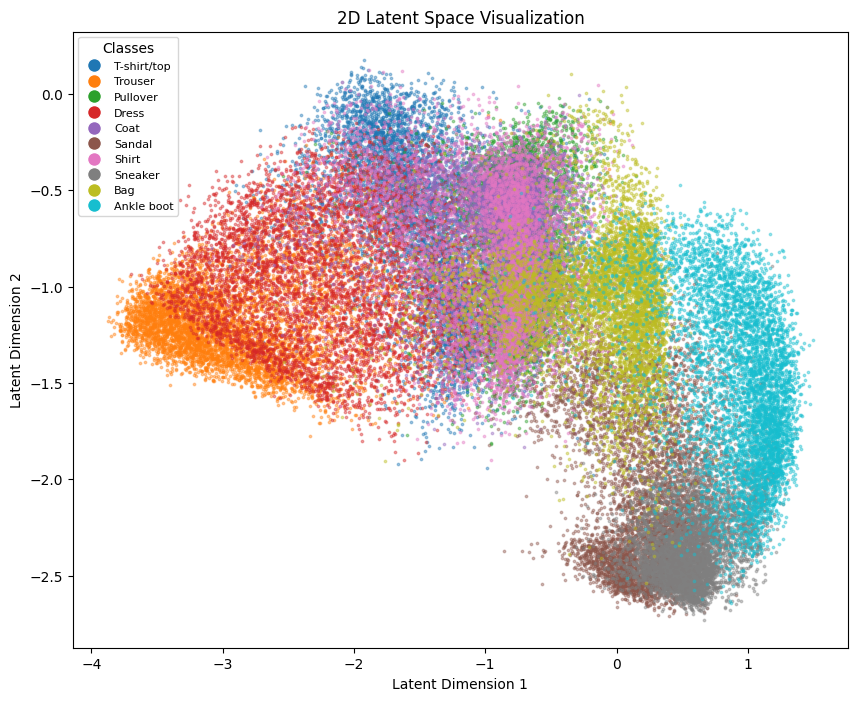

In [26]:
# Plot the 2D embeddings

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Scatter plot
plt.figure(figsize=(10, 8))
legend_handles = []
for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)[0]
    scatter = plt.scatter(
        embeddings[indices, 0], embeddings[indices, 1],
        c=[colors[i]], alpha=0.4, s=3, label=class_labels[label]
    )
    legend_handles.append(
        Line2D([0], [0], marker='o', color='w', label=f'{class_labels[label]}',
               markersize=10, markerfacecolor=colors[i])
    )

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization')
plt.legend(handles=legend_handles, title='Classes', loc='upper left', fontsize=8)
plt.show()


tensor([[ 0.8338, -0.8442],
        [-0.5899, -1.7102],
        [-1.1366, -0.5347],
        [ 1.0036,  2.2293],
        [-0.4233, -0.6996]])


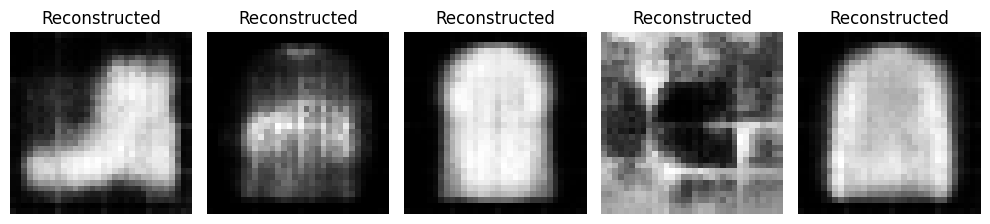

In [27]:
z_sample =  torch.tensor(np.random.normal(size=(5, 2)),dtype=torch.float32)
plot_reconstructions( vae, z_sample, ex=False)

torch.save(vae.state_dict(), "VAmodel_state_dict.pth")